In [10]:
%matplotlib inline
import numpy as np
import numpy.random as nprnd
import scipy as scp
import scipy.integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [11]:
rng1 = nprnd.default_rng(51049)

# model dimension
xdim = 40
# observational noise
sigmodel = 0.0
# time between observations
tdel = 0.05
# number of assimilation steps
nobs = 1000
# observation space dimension
ydim = 20
# the choice of observation operator
hobs = rng1.permutation(np.eye(ydim, xdim).T).T
# observational noise standard deviation
sigobs = 0.7
# whether to use localization or not
loc = True
# localization scale
l_scale = 4
# inflation factor
alpha = 1.02
# choice of initial ensemble (but we will see that this is
# not important "in the long run" i.e. asymptotically)
ebias = 5.0
ecov = 2.0
# ensemble size
nens = 50
# of course, very important is the choice of filter: perturbed obs,
# or square root, and if latter, then ETKF,
# or EAKF, or local ETKF (LETKF), etc.


In [12]:
def l96rhs(xin, tin, pars):
    F = pars
    # ndim, = xin.shape
    # frhs = (np.roll(xin,-1) - np.roll(xin,2)) * np.roll(xin,1) - xin + F
    return (np.roll(xin,-1) - np.roll(xin,2)) * np.roll(xin,1) - xin + F

#### another way:
#### the index rotation trick
# # index of the current grid point
# k00 = np.arange(ndim)
# # index for the next grid point
# kp1 = np.mod(np.arange(1,ndim+1), ndim)
# # index for the previous grid point
# km1 = np.mod(np.arange(-1,ndim-1), ndim)
# # index for previous to previous grid point
# km2 = np.mod(np.arange(-2,ndim-2), ndim)
# frhs = (xin[kp1] - xin[km2]) * xin[km1] - xin[k00] + F
#####

def l96rhs_df(xin, tin, pars):
    ndim, = xin.shape
    F = pars
    df = -np.eye(ndim)
    # index of the current grid point
    k00 = np.arange(ndim)
    # index for the next grid point
    kp1 = np.mod(np.arange(1,ndim+1), ndim)
    # index for the previous grid point
    km1 = np.mod(np.arange(-1,ndim-1), ndim)
    # index for previous to previous grid point
    km2 = np.mod(np.arange(-2,ndim-2), ndim)
    df[k00,km2] = -xin[km1]
    df[k00,km1] = xin[kp1] - xin[km2]
    df[k00,kp1] = xin[km1]
    #############
    ## NOTE: the right hand sides above can be easily obtained
    ## by using np.roll, BUT, I don't know how to use np.roll
    ## on the left hand side......
    #############
    return df


def l96rhslin(zin, tin, pars):
  F = pars
  zlen, = zin.shape
  nd = (np.sqrt(1+4*zlen) - 1)/2
  ndim = int(np.rint(nd));

  xin = zin[:ndim]
  mlin = np.reshape(zin[ndim:],(ndim,ndim),'F')

  df = l96rhs_df(xin, tin, pars)
  xin = l96rhs(xin, tin, pars)
  mlin = np.dot(df, mlin)

  frhs = np.concatenate((xin, np.reshape(mlin,ndim**2,'F')))
  return frhs


In [13]:
# defining the localization matrix in covariance localization scheme:
def gaspri(r, l_scale):
    #Defining the function as given in Alberto-Carassi DA-review paper
    r_=abs(r)/l_scale
    if 0.<=r_ and r_<1.:
        return 1.-(5./3)*r_**2+(5./8)*r_**3+(1./2)*r_**4-(1./4)*r_**5
    elif 1.<=r_ and r_<2.:
        return 4.-5.*r_+(5./3.)*r_**2+(5./8.)*r_**3-(1./2.)*r_**4+(1/12)*r_**5-2/(3*r_)
    else:
        return 0


In [14]:
def forecast(ens):
    ensout = ens*1.0
    xd, ne = ens.shape
    for ii in np.arange(ne):
      if (sigmodel > 0.0):
        ensout[:,ii] = scp.integrate.odeint(l96rhs, ens[:,ii], [0,tdel], (pars,))[1] + \
        rng1.multivariate_normal(np.zeros(xdim), model_cov)
      else:
        ensout[:,ii] = scp.integrate.odeint(l96rhs, ens[:,ii], [0,tdel], (pars,))[1]
    return ensout

In [15]:
def analysis_pertobs(forecast_ensemble, hobs, robs, perturbed_obs, alpha):
    P_f_H_T = (rho * np.cov(alpha * forecast_ensemble, rowvar=True))@np.transpose(hobs)
    Kalman_gain = P_f_H_T @ np.linalg.inv(hobs @ P_f_H_T + robs)
    innovations = perturbed_obs - hobs@forecast_ensemble
    analysis_ensemble = forecast_ensemble + Kalman_gain @ innovations
    return analysis_ensemble

Part a) 

In [16]:
### first find a point on the attractor, to be used
### as the "true" initial condition

F = 8.0;
pars = (F)
tout = np.linspace(0,500,200)
rng1 = nprnd.default_rng(51030)

#-- xdim = 40  ## already defined above
xin = -5.291506 + rng1.uniform(size=xdim) * 14.58193
xtrans = scp.integrate.odeint(l96rhs, xin, tout, (pars,))
xattr = xtrans[-1,:]

In [17]:
### Find the true discrete time trajectory

#-- sigmodel = 0.05 ## already defined above
model_cov = (sigmodel**2) * np.eye(xdim)

#-- tdel = 0.05 ## already defined above
#-- nobs = 1000 ## already defined above
tobs = np.linspace(0, tdel*nobs, nobs+1)

x0true = xtrans[-1,:]

if (sigmodel > 0.0):
  ## for stochastic trajectory, a `for` loop is necessary
  rng1 = nprnd.default_rng(51030)
  xtrue = np.zeros((nobs+1, xdim))
  xtrue[0,:] = x0true*1.0
  for ii in np.arange(1,nobs+1):
    xin = xtrue[ii-1,:]
    xtrue[ii,:] = scp.integrate.odeint(l96rhs, xin, [0,tdel], (pars,))[1] + \
    rng1.multivariate_normal(np.zeros(xdim), model_cov)
else:
  ## deterministic trajectory can be found simply using `odeint`
  xtrue = scp.integrate.odeint(l96rhs, x0true, tobs, (pars,))


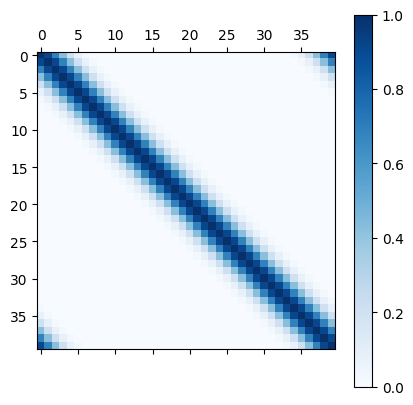

In [23]:
if loc:
    rho=np.asarray([[gaspri(min(abs(i-j),abs(xdim-abs(i-j))), l_scale) for j in range(xdim)]for i in range(xdim)])
else:
    rho=np.ones((xdim,xdim))

plt.matshow(rho, cmap=plt.cm.Blues)
plt.colorbar()

Part b)

In [18]:
rng1 = nprnd.default_rng(571692018)

#-- ydim = 20  ## already defined above
#-- hobs = rng1.permutation(np.eye(ydim, xdim).T).T  ## already defined above
#-- sigobs = 0.7  ## already defined above
ob_cov=(sigobs**2) * np.eye(ydim)

yobs = (hobs@(xtrue.T)).T + \
np.random.multivariate_normal(np.zeros(len(hobs)), \
                              ob_cov, xtrue.shape[0])

In [38]:

def compute_and_plot_enkf(label, ebias, ecov, nens, xtrue, xdim, nobs, yobs, ob_cov, hobs, alpha, tobs, ydim, sigobs):
    initial_ensemble = nprnd.multivariate_normal(xtrue[0]+ebias,ecov*np.eye(xdim),nens).T
    store_filtered_ensemble = np.zeros((nobs,xdim,nens))

    # Running enkf below
    ensemble = initial_ensemble*1.0
    store_filtered_ensemble[0] = initial_ensemble
    for i in range(1,nobs):
        ensemble_predicted = forecast(ensemble)
        ensemble_perturbed_observations = nprnd.multivariate_normal(yobs[i],ob_cov,nens).T
        ensemble_filtered = analysis_pertobs(ensemble_predicted, hobs, ob_cov, ensemble_perturbed_observations, alpha)
        store_filtered_ensemble[i] = ensemble_filtered
        ensemble = ensemble_filtered*1.0
    
    rmse = np.linalg.norm(xtrue[1:,:] - np.mean(store_filtered_ensemble,axis=2), axis=1)
    plt.figure(figsize=(16,8))
    t_start, t_stop = 600, tobs.shape[0] - 1
    comp=6
    plt.plot(tobs[t_start:t_stop],store_filtered_ensemble[t_start:t_stop,comp],c='cyan',alpha=0.4)
    plt.plot(tobs[t_start:t_stop],xtrue[t_start:t_stop,comp],c='y', label='true')
    plt.plot(tobs[t_start:t_stop],np.mean(store_filtered_ensemble[t_start:t_stop,comp],axis=1),c='r', label='filter mean')
    for ii in np.arange(ydim):
        if hobs[ii,comp]==1:
            plt.errorbar(tobs[t_start:t_stop],yobs[t_start:t_stop,ii],yerr=sigobs,c='r',mec='black',mfc='g',capsize=4,fmt='.',ms=13)
    plt.legend()
    plt.title(label+" initial conditions")
    plt.show()
    return store_filtered_ensemble

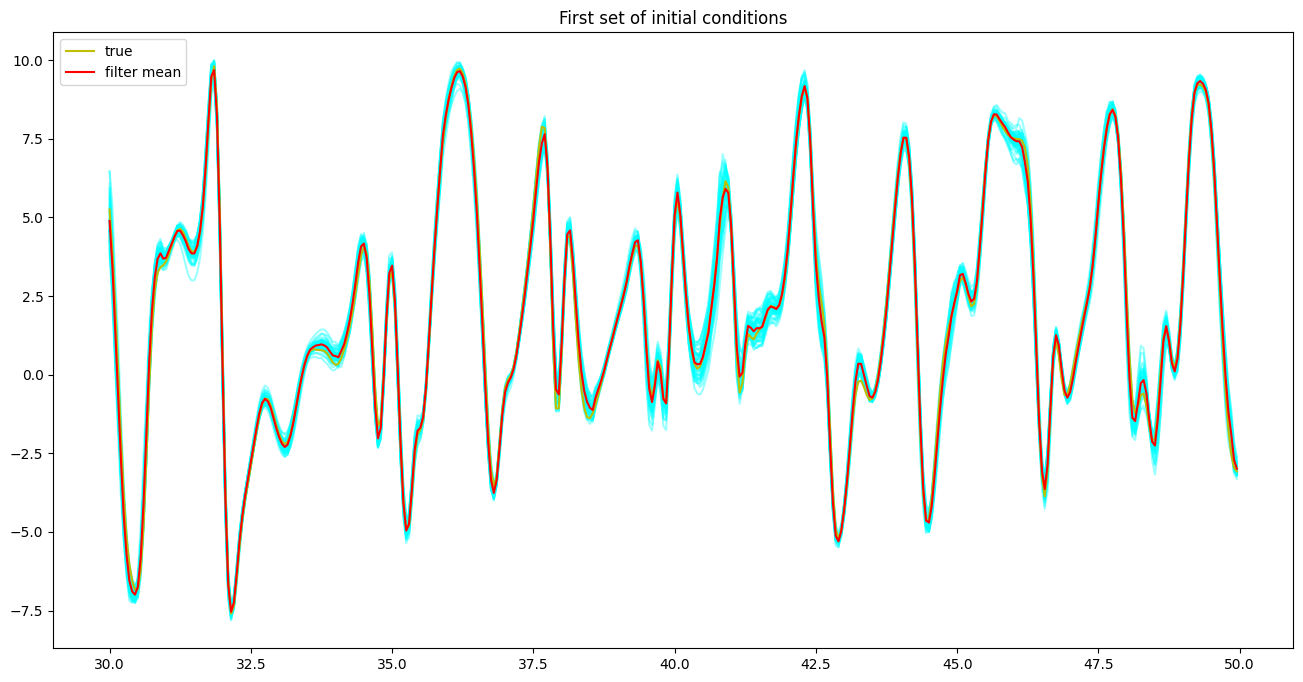

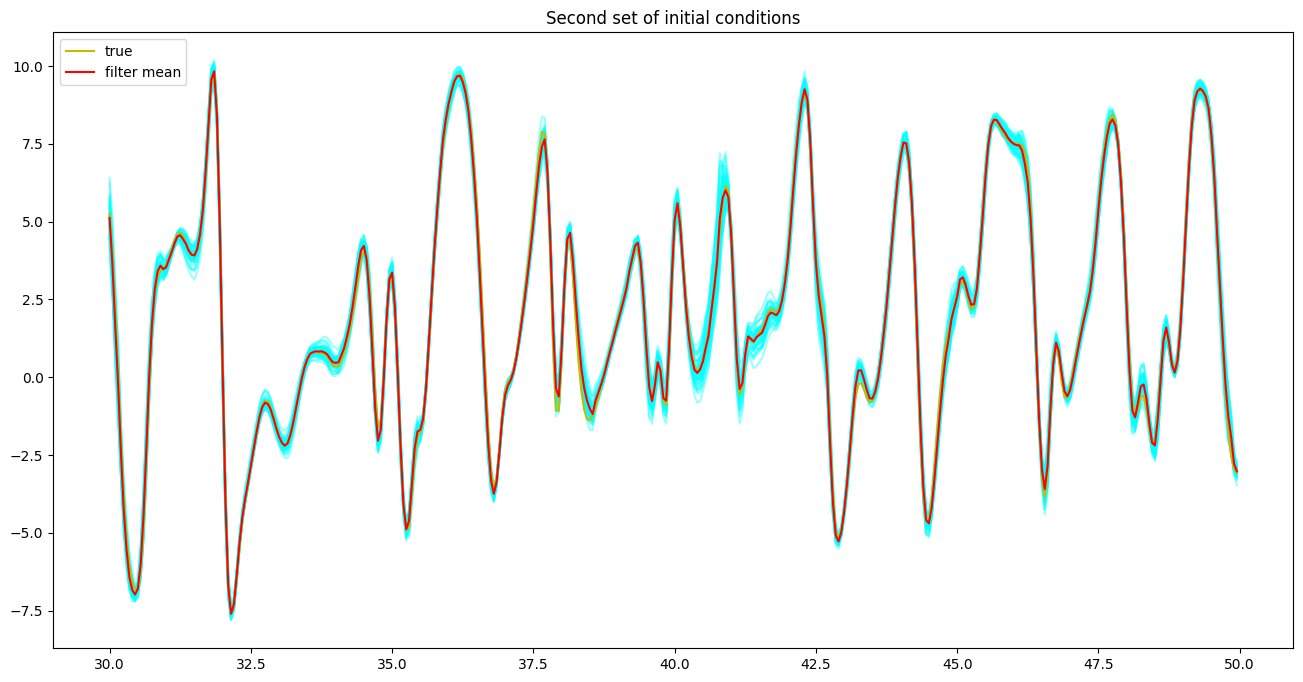

In [40]:
# Generate initial ensemble

ebias_1 = 5.0;   ebias_2= 2.0
ecov_1 = 2.0;  ecov_2 = 4.0
nens_1 = 50;   nens_2= 50

store_filtered_ensemble_1 = compute_and_plot_enkf("First set of",ebias_1, ecov_1, nens_1, xtrue, xdim, nobs, yobs, ob_cov, hobs, alpha, tobs, ydim, sigobs)
store_filtered_ensemble_2 = compute_and_plot_enkf("Second set of",ebias_2, ecov_2, nens_2, xtrue, xdim, nobs, yobs, ob_cov, hobs, alpha, tobs, ydim, sigobs)

# Plot the initial ensemble and the truth at t=0

In [116]:
# null= np.zeros(1000)
def find_norm_given_ensemble(store_filtered_ensemble):
    null, null_var=[], []
    for comp in range(0,40):
        null.append(np.mean(store_filtered_ensemble[:,comp], axis=1))
        null_var.append(np.var(store_filtered_ensemble[:,comp], axis=1))
    null=np.array(null)
    null_var= np.array(null_var)
    return np.linalg.norm(null, axis=0), np.linalg.norm(null_var, axis=0)

Text(0.5, 1.0, 'difference in variance between the two ensembles')

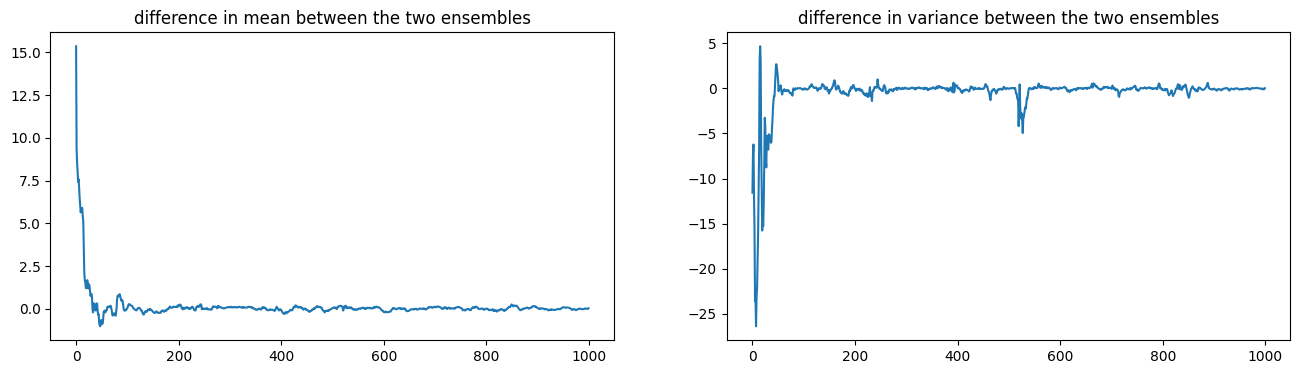

In [123]:

mean1, var1= find_norm_given_ensemble(store_filtered_ensemble_1)
mean2, var2= find_norm_given_ensemble(store_filtered_ensemble_2)
difference_mean = mean1 - mean2
difference_var = var1 - var2
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(difference_mean)
plt.title(f"difference in mean between the two ensembles")
plt.subplot(122)
plt.plot(difference_var)
plt.title(f"difference in variance between the two ensembles")

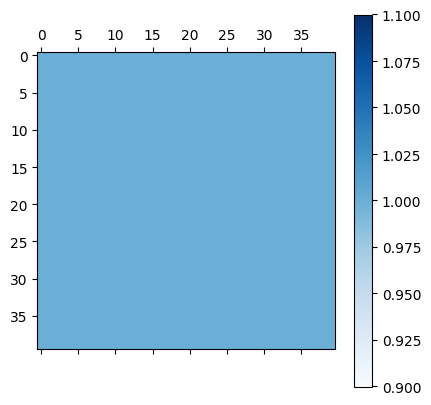

In [77]:
loc = False
l_scale = 4
if loc:
    rho=np.asarray([[gaspri(min(abs(i-j),abs(xdim-abs(i-j))), l_scale) for j in range(xdim)]for i in range(xdim)])
else:
    rho=np.ones((xdim, xdim))

plt.matshow(rho, cmap=plt.cm.Blues)
plt.colorbar()

alpha = 1.0

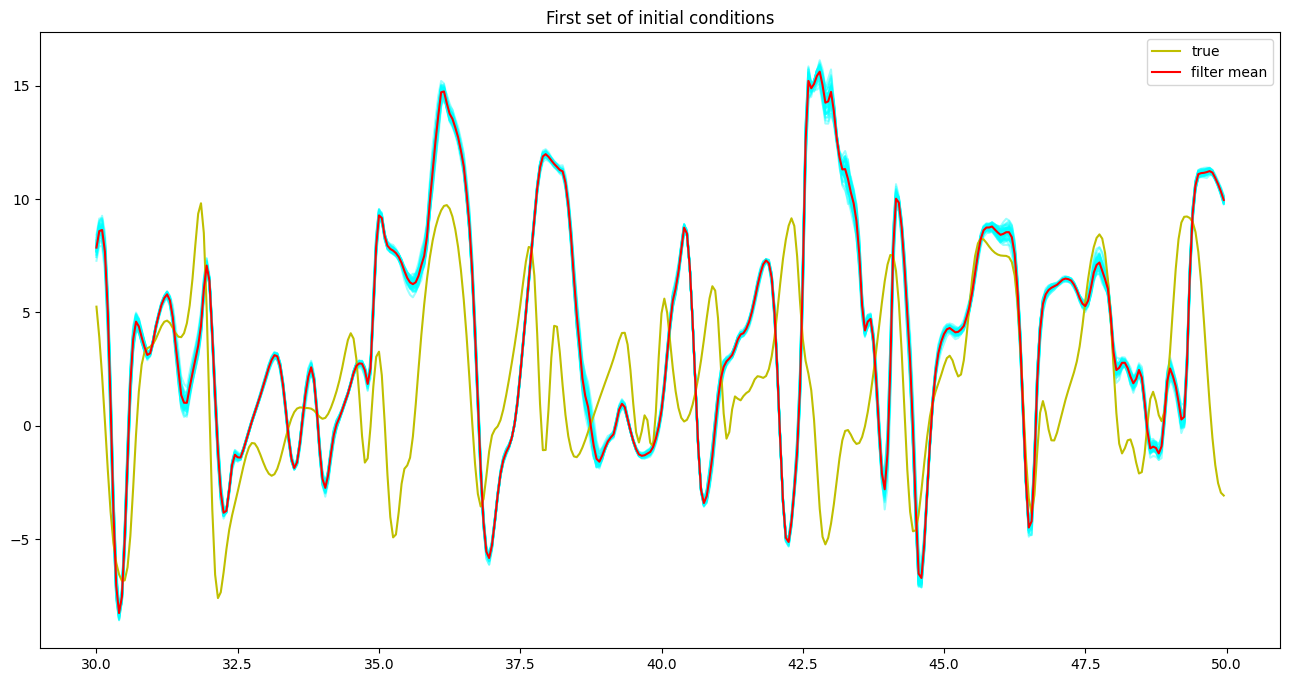

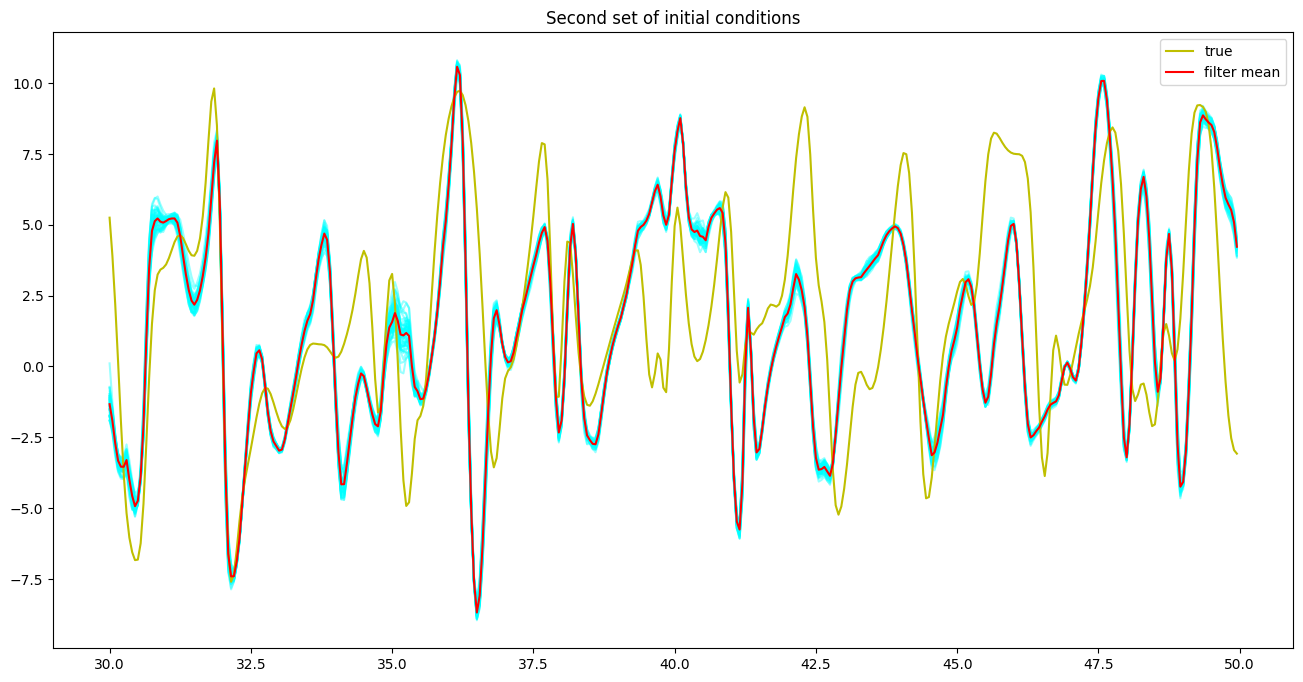

In [78]:
# Generate initial ensemble

store_filtered_ensemble_1_no_loc = compute_and_plot_enkf("First set of",ebias_1, ecov_1, nens_1, xtrue, xdim, nobs, yobs, ob_cov, hobs, alpha, tobs, ydim, sigobs)
store_filtered_ensemble_2_no_loc= compute_and_plot_enkf("Second set of",ebias_2, ecov_2, nens_2, xtrue, xdim, nobs, yobs, ob_cov, hobs, alpha, tobs, ydim, sigobs)

# Plot the initial ensemble and the truth at t=0

Text(0.5, 1.0, 'difference in variance between the two ensembles no loc')

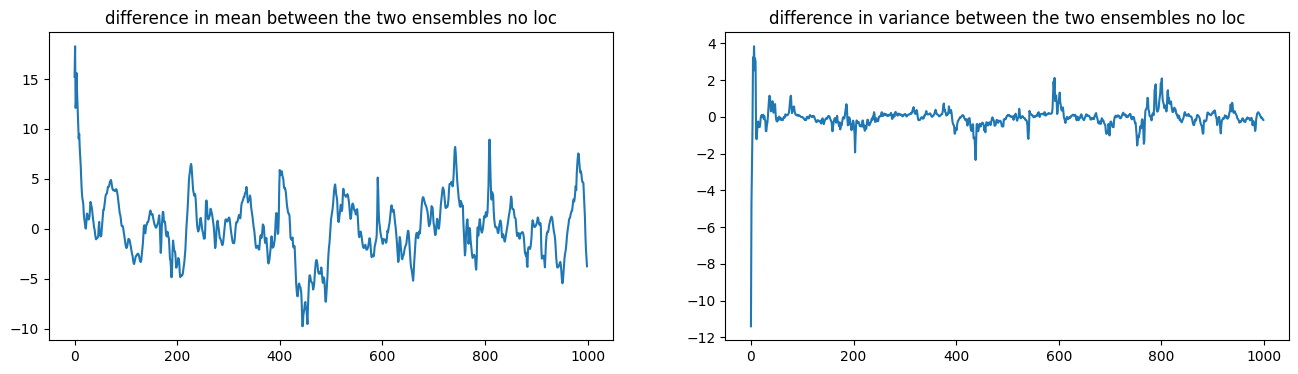

In [119]:
mean1, var1= find_norm_given_ensemble(store_filtered_ensemble_1_no_loc)
mean2, var2= find_norm_given_ensemble(store_filtered_ensemble_2_no_loc)
difference_mean = mean1 - mean2
difference_var = var1 - var2
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(difference_mean)
plt.title(f"difference in mean between the two ensembles no loc")
plt.subplot(122)
plt.plot(difference_var)
plt.title(f"difference in variance between the two ensembles no loc")

Ensemble with localisation stabilizes but ensemble without localisation does not